In [1]:
# Imports

import tensorflow as tf
import cv2
import os
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from glob import glob
from random import shuffle
import numpy as np

In [2]:
# Fix to tensorflow bug using CUDA  
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# source: https://github.com/tensorflow/tensorflow/issues/24828#issuecomment-464910864

In [3]:
DATADIR = "Dataset/"
NO_CLASS_LABEL='noclass'
IMG_SIZE = 150
IMG_CHANNELS=3
TRAIN_TEST_RATIO = 0.2

In [4]:
# Get train_addrs and valid_addrs
train_folders = glob(os.path.join(DATADIR,'seg_train','seg_train','*'))
valid_folders = glob(os.path.join(DATADIR,'seg_test','seg_test','*'))

train_addrs = []
valid_addrs = []

for (index, path) in enumerate(train_folders):
    img_addrs = glob(os.path.join(path,"*"))
    for img_addr in img_addrs:
        train_addrs.append((img_addr, index))
        
for (index, path) in enumerate(valid_folders):
    img_addrs = glob(os.path.join(path,"*"))
    for img_addr in img_addrs:
        valid_addrs.append((img_addr, index))

label_count = len(train_folders)
shuffle(train_addrs)
shuffle(valid_addrs)

In [5]:
labels = [x.split('/')[-1] for x in train_folders]
print("labels = ", labels)

labels =  ['sea', 'glacier', 'street', 'forest', 'buildings', 'mountain']


In [6]:
# Read dataset into memory
x_train = np.zeros( (len(train_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.float32 ) # Keras input: (img_height, img_width, img_depth)
y_train_list = np.zeros( len(train_addrs), dtype=np.int )

x_valid = np.zeros( (len(valid_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.float32 )
y_valid_list = np.zeros( len(valid_addrs), dtype=np.int )

# Train data
for i in range(len(train_addrs)):
    addr = train_addrs[i][0]
    label = train_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_train[i, ...] = img * 1.0/255.0
    y_train_list[i] = label
    
# Validation data
for i in range(len(valid_addrs)):    
    addr = valid_addrs[i][0]
    label = valid_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_valid[i, ...] = img * 1.0/255.0
    y_valid_list[i] = label

In [7]:
# One hot encode labels
y_train = np.zeros((y_train_list.shape[0],label_count),dtype=np.float32)
y_valid = np.zeros((y_valid_list.shape[0],label_count),dtype=np.float32)

y_train[np.arange(y_train.shape[0]), y_train_list] = 1.0
y_valid[np.arange(y_valid.shape[0]), y_valid_list] = 1.0

In [50]:
# Custom generator to train on the fly (because tensorflow 2 bug consumes double RAM)
# a generator that yields items instead of returning a list

def generate_train(batch_size):
    
    samples = x_train.shape[0]
    indices = list(range(samples))
    
    x_return = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.float32)
    y_return = np.zeros((batch_size, label_count), dtype=np.float32)
    
    while True:
        shuffle(indices)
        n = 0
        
        while n+batch_size < samples:
            mask = list(range(n,n+batch_size))
            n+= batch_size
            
            x_return = x_train[mask]
            y_return = y_train[mask]
            
            yield (x_return, y_return)

def generate_valid(batch_size):
    
    samples = x_valid.shape[0]
    indices = list(range(samples))
    
    x_return = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.float32)
    y_return = np.zeros((batch_size, label_count), dtype=np.float32)

    while True:
        shuffle(indices)
        n = 0
        
        while n+batch_size < samples:
            mask = list(range(n,n+batch_size))
            n+= batch_size
            
            x_return = x_valid[mask]
            y_return = y_valid[mask]
            
            yield (x_return, y_return)


In [27]:
gen = generate_valid(20)

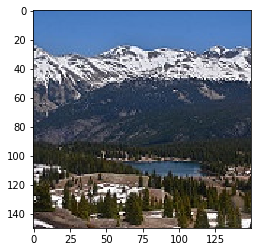

mountain


In [49]:
# Test custom generator
import matplotlib.pyplot as plt

index = 0

x,y = next(gen)
plt.imshow(x[index])
plt.show()
print(labels[np.argmax(y[index])])

In [10]:
# Define and test Keras generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0,)

index = 3

# Uncomment to test keras generator
'''
gen = datagen.flow(x_train, y_train, batch_size=20)
x,y = gen.next()
plt.imshow(x[index])
plt.show()
print(y[index])
'''

'\ngen = datagen.flow(x_train, y_train, batch_size=20)\nx,y = gen.next()\nplt.imshow(x[index])\nplt.show()\nprint(y[index])\n'

In [11]:
# Find class weights
class_weight = {x:0 for x in range(label_count)}
for i in range(len(y_train)):
    class_weight[np.argmax(y_train[i])]+=1

weights0 = class_weight[0]*1.0    
for k,v in class_weight.items():
    class_weight[k]/=weights0
    
print("Class weights:", class_weight)

Class weights: {0: 1.0, 1: 1.0571679859278804, 2: 1.0474934036939314, 3: 0.9986807387862797, 4: 0.9635004397537379, 5: 1.1046613896218118}


In [19]:
# Define model

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.losses import *

rmsprop = optimizers.RMSprop(learning_rate=0.0008, rho=0.9, momentum=0.0001)

in_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name='input_layer', dtype=tf.float32)
x = Conv2D(64, kernel_size=5, activation='relu', name='convo1')(in_img)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=3, activation='relu', name='convo2')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)

x = Conv2D(256, kernel_size=3, activation='relu', name='convo3')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)

x = Conv2D(256, kernel_size=3, activation='relu', name='convo4')(x)
x = Conv2D(256, kernel_size=1, activation='relu', padding="same")(x)

x = Conv2D(512, kernel_size=3, activation='relu', name='convo5')(x)

x = Conv2D(512, kernel_size=3, activation='relu', name='convo6')(x)
x = Conv2D(512, kernel_size=1, activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)

output = Dense(label_count, activation='softmax', name='output_layer', dtype=tf.float32)(x)

model = Model(inputs=in_img, outputs=output)
model.compile(optimizer=rmsprop, 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
convo1 (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
convo2 (Conv2D)              (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 35, 35, 128)       16512     
_________________________________________________________________
convo3 (Conv2D)              (None, 33, 33, 256)       2951

In [53]:
# Load weights
#model.load_weights('pre-trained.h5')
model.load_weights('trained.h5')

In [54]:
epochs = 10
batch_size = 16

# Error because of lack of RAM

# model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
#                     validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
#                     class_weight = class_weight)


# # Custom generator, to avoid out of RAM error

gen_train = generate_train(batch_size)
gen_valid = generate_valid(batch_size)
model.fit(gen_train,
        steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
        validation_data=gen_valid,
        class_weight = class_weight)

# model.fit(generate_train(batch_size),
#                     steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
#                     class_weight = class_weight)


# Without using generator

# model.fit(x_train, y_train,
#         batch_size=batch_size,
#         epochs=epochs,
#         steps_per_epoch=len(x_train) / batch_size,
#         validation_data=(x_valid, y_valid),
#         class_weight = class_weight)

Epoch 1/10
878/877 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.6951

KeyboardInterrupt: 

In [ ]:
# Evaluate model

val_loss, val_acc = model.evaluate(x_valid, y_valid);
print(val_loss)
print(val_acc)

In [55]:
# Save weights hdf5 format

#model.save_weights('pre-trained.h5')
model.save_weights('trained.h5')

In [56]:
# Save model in SavedModel format (tensorflow 2)

export_path = 'model'

tf.saved_model.save(model, export_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
# Load model and test signature def (Tensorflow 2)

import numpy as np
import matplotlib.pyplot as plt

# Load model
loaded_model = tf.keras.models.load_model('model') 

# Predict function 
predict = loaded_model.signatures["serving_default"]

In [ ]:
# Predict using loaded model

index = 12

# Define input image
img = x_valid[index:index+1]/255.0

# Predict
prediction = predict(tf.constant(img, dtype=tf.float32))

# Show results
plt.imshow(x_valid[index])  # prints the image
print(prediction['graph_output'][0])  # prints the class number
print(labels_str[np.argmax(prediction['graph_output'][0])])

In [ ]:
prediction['graph_output'][0].numpy()

In [ ]:
a